### RSI Based Momentum Trading Strategy Backtested using zipline for NIFTY 100 as Stocks Universe

In [36]:
# Necessary imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import zipline
from zipline.api import (order_target_percent, symbol, set_commission, set_slippage,
                         schedule_function, date_rules, time_rules)
from datetime import datetime
import matplotlib.pyplot as plt
import pyfolio as pf
import pandas as pd
import numpy as np  
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage
import talib as ta
import pytz
import pandas_datareader.data as web
from os import listdir

In [37]:
# for dataframe slicing operations
idx = pd.IndexSlice

### Data Gathering to Create Custome bundle in zipline

In [38]:
# # Path to data store
# DATA_STORE = '../../machine-learning-for-trading-master/machine-learning-for-trading-master/data/nse_asset.h5'

In [39]:
# # list the contents of data store
# with pd.HDFStore(DATA_STORE) as store:
#     print(store.info())

In [40]:
# # Fetch nifty 100 metadata
# with pd.HDFStore(DATA_STORE) as store:
#     nify100_meta = (store['/nse/nse100/meta'])
# nify100_meta.head(2)

In [41]:
# # Write it back as csv for reference
# nify100_meta.to_csv('data/nifty100_meta.csv', index=False)

In [42]:
# # Read back the csv file
# nify100_meta = pd.read_csv('data/nifty100_meta.csv')
# nify100_meta.head(2)

In [43]:
# # Generate the ticker list
# tickers = list(nify100_meta.Symbol)
# print(tickers)

In [44]:
# Testing date range
start = datetime(2010, 1, 1, 8, 15, 12, 0, pytz.UTC)
end = datetime(2020, 6, 15, 8, 15, 12, 0, pytz.UTC)

In [45]:
# # columns to fetch
# cols = ['open','low','high','close','volume']

# # get the nifty 100 stocks daily price data
# with pd.HDFStore(DATA_STORE) as store:
#     prices = (store['/nse/nse500/prices'].loc[idx[tickers, start:end], cols])
# prices.tail(2)

In [46]:
# # take tickers with mim 10 years of records
# min_obs = 2520
# nobs = prices.groupby(level='ticker').size()
# keep = nobs[nobs>min_obs].index

# prices = prices.loc[idx[keep,:], :]
# prices.info()

In [47]:
# # final list of tickers
# TICKERS = list(prices.index.get_level_values('ticker').unique())
# len(TICKERS)


In [48]:
TICKERS = [f[:-4] for f in listdir('data/data/')]
print(TICKERS)
print(len(TICKERS))

['ACC', 'ADANIPORTS', 'AMBUJACEM', 'ASHOKLEY', 'ASIANPAINT', 'AUROPHARMA', 'AXISBANK', 'BAJAJFINSV', 'BAJAJHLDNG', 'BAJFINANCE', 'BANKBARODA', 'BERGEPAINT', 'BHARTIARTL', 'BIOCON', 'BOSCHLTD', 'BPCL', 'BRITANNIA', 'CADILAHC', 'CIPLA', 'COLPAL', 'CONCOR', 'DABUR', 'DIVISLAB', 'DLF', 'DRREDDY', 'EICHERMOT', 'GAIL', 'GODREJCP', 'GRASIM', 'HAVELLS', 'HCLTECH', 'HDFC', 'HDFCBANK', 'HEROMOTOCO', 'HINDALCO', 'HINDPETRO', 'HINDUNILVR', 'HINDZINC', 'ICICIBANK', 'IDEA', 'INDUSINDBK', 'INFY', 'IOC', 'ITC', 'JSWSTEEL', 'KOTAKBANK', 'LT', 'LUPIN', 'M&M', 'MARICO', 'MARUTI', 'MOTHERSUMI', 'NESTLEIND', 'NHPC', 'NMDC', 'NTPC', 'OFSS', 'ONGC', 'PAGEIND', 'PEL', 'PETRONET', 'PFC', 'PGHH', 'PIDILITIND', 'PNB', 'POWERGRID', 'RELIANCE', 'SBIN', 'SHREECEM', 'SIEMENS', 'SRTRANSFIN', 'SUNPHARMA', 'TATAMOTORS', 'TATAMTRDVR', 'TATASTEEL', 'TCS', 'TECHM', 'TITAN', 'UBL', 'ULTRACEMCO', 'UPL', 'VEDL', 'WIPRO', 'ZEEL']
84


In [49]:
# # write csv files for each ticker
# for ticker in TICKERS:
#     print('Processing...',ticker)
#     df = prices.loc[ticker]
#     # remove any duplicate
#     df = df[~df.index.duplicated()]
#     # resample daily
#     df = df.asfreq('D', method='ffill')
#     # write to csv
#     df.to_csv('data/data/{}.csv'.format(ticker))

Follow the article to create your own custom bundle for zipline

https://medium.com/@sabirh.jana/how-to-import-indian-equities-data-to-zipline-on-your-local-machine-3b8587aaf112?source=friends_link&sk=5d8214e625b2626b361f64cc849acc38

### Backtesting Startegy

In [50]:
# Define Model Parameters
intial_portfolio = 500000
upper = 70
lower = 30
rsi_period = 14
vola_window = 20
mportfolio_size = 30

# Commission and Slippage Parameters
enable_commission = True
commission_pct = 0.004
enable_slippage = True 
slippage_volume_limit = 0.025
slippage_impact = 0.05

In [51]:
# function to calculate RSI
def compute_rsi(close):
    rsi = ta.RSI(close.values, timeperiod=rsi_period)
    return rsi[-1]

In [52]:
# function to calculate volatility
def volatility(ts):
    std = ts.pct_change().dropna().rolling(vola_window).std().mean() #iloc[-1]
    return std

In [53]:
# output performance
def output_progress(context):
    # Output performance numbers during backtest run on monthly basis
    # Get today's date
    today = zipline.api.get_datetime().date()
    
    # Calculate percent difference since last month
    perf_pct = (context.portfolio.portfolio_value / context.last_month) - 1
    
    # Print performance, format as percent with two decimals.
    print("{} - Last Month Result: {:.2%}".format(today, perf_pct))
    
    # Remember today's portfolio value for next month's calculation
    context.last_month = context.portfolio.portfolio_value

In [54]:
# Initialization the trading logic
def initialize(context):
   
    # Set commission and slippage.
    if enable_commission:
        comm_model = PerDollar(cost=commission_pct)
    else:
        comm_model = PerDollar(cost=0.0)
    set_commission(comm_model)
    
    if enable_slippage:
        slippage_model=VolumeShareSlippage(volume_limit=slippage_volume_limit, price_impact=slippage_impact)
    else:
        slippage_model=FixedSlippage(spread=0.0)   
    set_slippage(slippage_model)    
    
    # Used only for progress output.
    context.last_month = intial_portfolio
    
    # Fetch and store index tickers
    context.index_members = TICKERS
    
    #Schedule rebalance monthly.
    schedule_function(
        func=rebalance,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open()
    )

In [55]:
def rebalance(context, data):

    # Write progress output during the backtest
    output_progress(context)
    
    # Finally, get the Zipline symbols for the tickers
    universe = [symbol(ticker) for ticker in context.index_members]
    
    # Get historical data for volatility calculation
    hist = data.history(universe, "close", 126, "1d")
    hist = hist.dropna()
    
    # Make momentum ranking table based on RSI
    ranking_table = hist.apply(compute_rsi).sort_values(ascending=True)  
    ranking_table.to_csv('data/ranking_table.csv')

    # Sell Logic
    # First we check if any existing position should be sold.
    # Sell if stock has RSI greater than upper value.
    kept_positions = list(context.portfolio.positions.keys())
    for security in context.portfolio.positions:
        if (security not in universe):
            order_target_percent(security, 0.0)
            kept_positions.remove(security)
        elif ranking_table[security] > upper:
            order_target_percent(security, 0.0)
            kept_positions.remove(security)
    
    # Stock Selection Logic
    # Check how many stocks we are keeping from last month.
    # Take the desired number of stock from the ranking table where RSI is less than lower.
    replacement_stocks = mportfolio_size - len(kept_positions)
    buy_list = ranking_table.loc[~ranking_table.index.isin(kept_positions)]
    buy_list = buy_list[buy_list.loc[buy_list.index] < lower].dropna()[:replacement_stocks]    
    new_portfolio = pd.concat((buy_list,ranking_table.loc[ranking_table.index.isin(kept_positions)]))
    

    # Calculate inverse volatility for stocks,and make target position weights.
    vola_table = hist[new_portfolio.index].apply(volatility)
    inv_vola_table = 1 / vola_table 
    sum_inv_vola = np.sum(inv_vola_table)         
    vola_target_weights = inv_vola_table / sum_inv_vola
    
    # Rebalance the tickers based on new weights
    for security, rank in new_portfolio.iteritems():
        weight = vola_target_weights[security]
        if security in kept_positions:
            order_target_percent(security, weight)
        else:
            if ranking_table[security] < lower:
                order_target_percent(security, weight)


In [56]:
def analyze(context, perf):
    perf['max'] = perf.portfolio_value.cummax()
    perf['dd'] = (perf.portfolio_value / perf['max']) - 1
    maxdd = perf['dd'].min()
    ann_ret = (np.power((perf.portfolio_value.iloc[-1] / perf.portfolio_value.iloc[0]),(252 / len(perf)))) - 1
    print("Annualized Return: {:.2%} Max Drawdown: {:.2%}".format(ann_ret, maxdd))
    return  

In [57]:
perf = zipline.run_algorithm(
    start=start, end=end, 
    initialize=initialize, 
    analyze=analyze, 
    capital_base=intial_portfolio,  
    data_frequency = 'daily', 
    bundle= 'nse_data')

2010-01-04 - Last Month Result: 0.00%
2010-02-01 - Last Month Result: 0.00%
2010-03-01 - Last Month Result: 3.28%
2010-04-01 - Last Month Result: 3.39%
2010-05-03 - Last Month Result: 3.53%
2010-06-01 - Last Month Result: -4.79%
2010-07-01 - Last Month Result: 8.42%
2010-08-02 - Last Month Result: 1.22%
2010-09-01 - Last Month Result: 2.15%
2010-10-01 - Last Month Result: 14.55%
2010-11-01 - Last Month Result: -2.02%
2010-12-01 - Last Month Result: -3.10%
2011-01-03 - Last Month Result: 3.17%
2011-02-01 - Last Month Result: -8.36%
2011-03-01 - Last Month Result: 1.62%
2011-04-01 - Last Month Result: 7.47%
2011-05-02 - Last Month Result: -0.84%
2011-06-01 - Last Month Result: 2.77%
2011-07-01 - Last Month Result: 0.09%
2011-08-01 - Last Month Result: 2.29%
2011-09-01 - Last Month Result: -6.29%
2011-10-03 - Last Month Result: -1.65%
2011-11-01 - Last Month Result: 8.26%
2011-12-01 - Last Month Result: -4.94%
2012-01-03 - Last Month Result: -6.82%
2012-02-01 - Last Month Result: 11.08%
2

### Performance analysis

In [58]:
# Extract inputs for pyfolio
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
print(returns[:3])
returns.name = 'Strategy' 

2010-01-04 00:00:00+00:00    0.0
2010-01-05 00:00:00+00:00    0.0
2010-01-06 00:00:00+00:00    0.0
Name: returns, dtype: float64


In [59]:
# # list the contents of data store
# with pd.HDFStore(DATA_STORE) as store:
#     print(store.info())

In [60]:
# # Fetch nifty 100 metadata
# with pd.HDFStore(DATA_STORE) as store:
#     benchmark = (store['/nse/nse500/prices'].loc['NIFTY100'])
# benchmark.head(3)

In [61]:
# # write to csv file
# benchmark.to_csv('data/nifty100.csv')

In [62]:
benchmark = pd.read_csv('data/nifty100.csv', index_col = [0], parse_dates=True)
benchmark.tail(3)

close  dividend      high       low      open  split     volume
date                                                                          
2020-06-16  10097.35       NaN  10230.60   9917.40  10200.45    NaN  2063440.0
2020-06-17  10069.75       NaN  10186.15  10020.95  10060.15    NaN  1459839.0
2020-06-18  10258.15       NaN  10276.90  10033.15  10051.45    NaN  1868154.0

In [63]:
# Get the benchmark prices for comparison
benchmark_prices = benchmark['close'].loc[start:end]
benchmark_prices = benchmark_prices.asfreq('D', method='ffill')
benchmark_prices.index = benchmark_prices.index.tz_localize('UTC')
benchmark_prices = benchmark_prices.filter(returns.index)
benchmark_prices.head(5)

date
2010-01-04 00:00:00+00:00    5153.55
2010-01-05 00:00:00+00:00    5203.80
2010-01-06 00:00:00+00:00    5214.00
2010-01-07 00:00:00+00:00    5191.70
2010-01-08 00:00:00+00:00    5175.75
Name: close, dtype: float64

In [64]:
# Rebase the benchmark prices for comparison
benchmark_prices = (benchmark_prices/benchmark_prices.iloc[0]) * intial_portfolio
benchmark_prices.head()

date
2010-01-04 00:00:00+00:00    500000.000000
2010-01-05 00:00:00+00:00    504875.280147
2010-01-06 00:00:00+00:00    505864.889251
2010-01-07 00:00:00+00:00    503701.332091
2010-01-08 00:00:00+00:00    502153.855110
Name: close, dtype: float64

In [65]:
# Get benchmark returns
benchmark_rets= benchmark['close'].loc[start:end].pct_change().dropna()
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'S&P Nifty-100'
benchmark_rets.head(2)

date
2010-01-05 00:00:00+00:00    0.009751
2010-01-06 00:00:00+00:00    0.001960
Name: S&P Nifty-100, dtype: float64

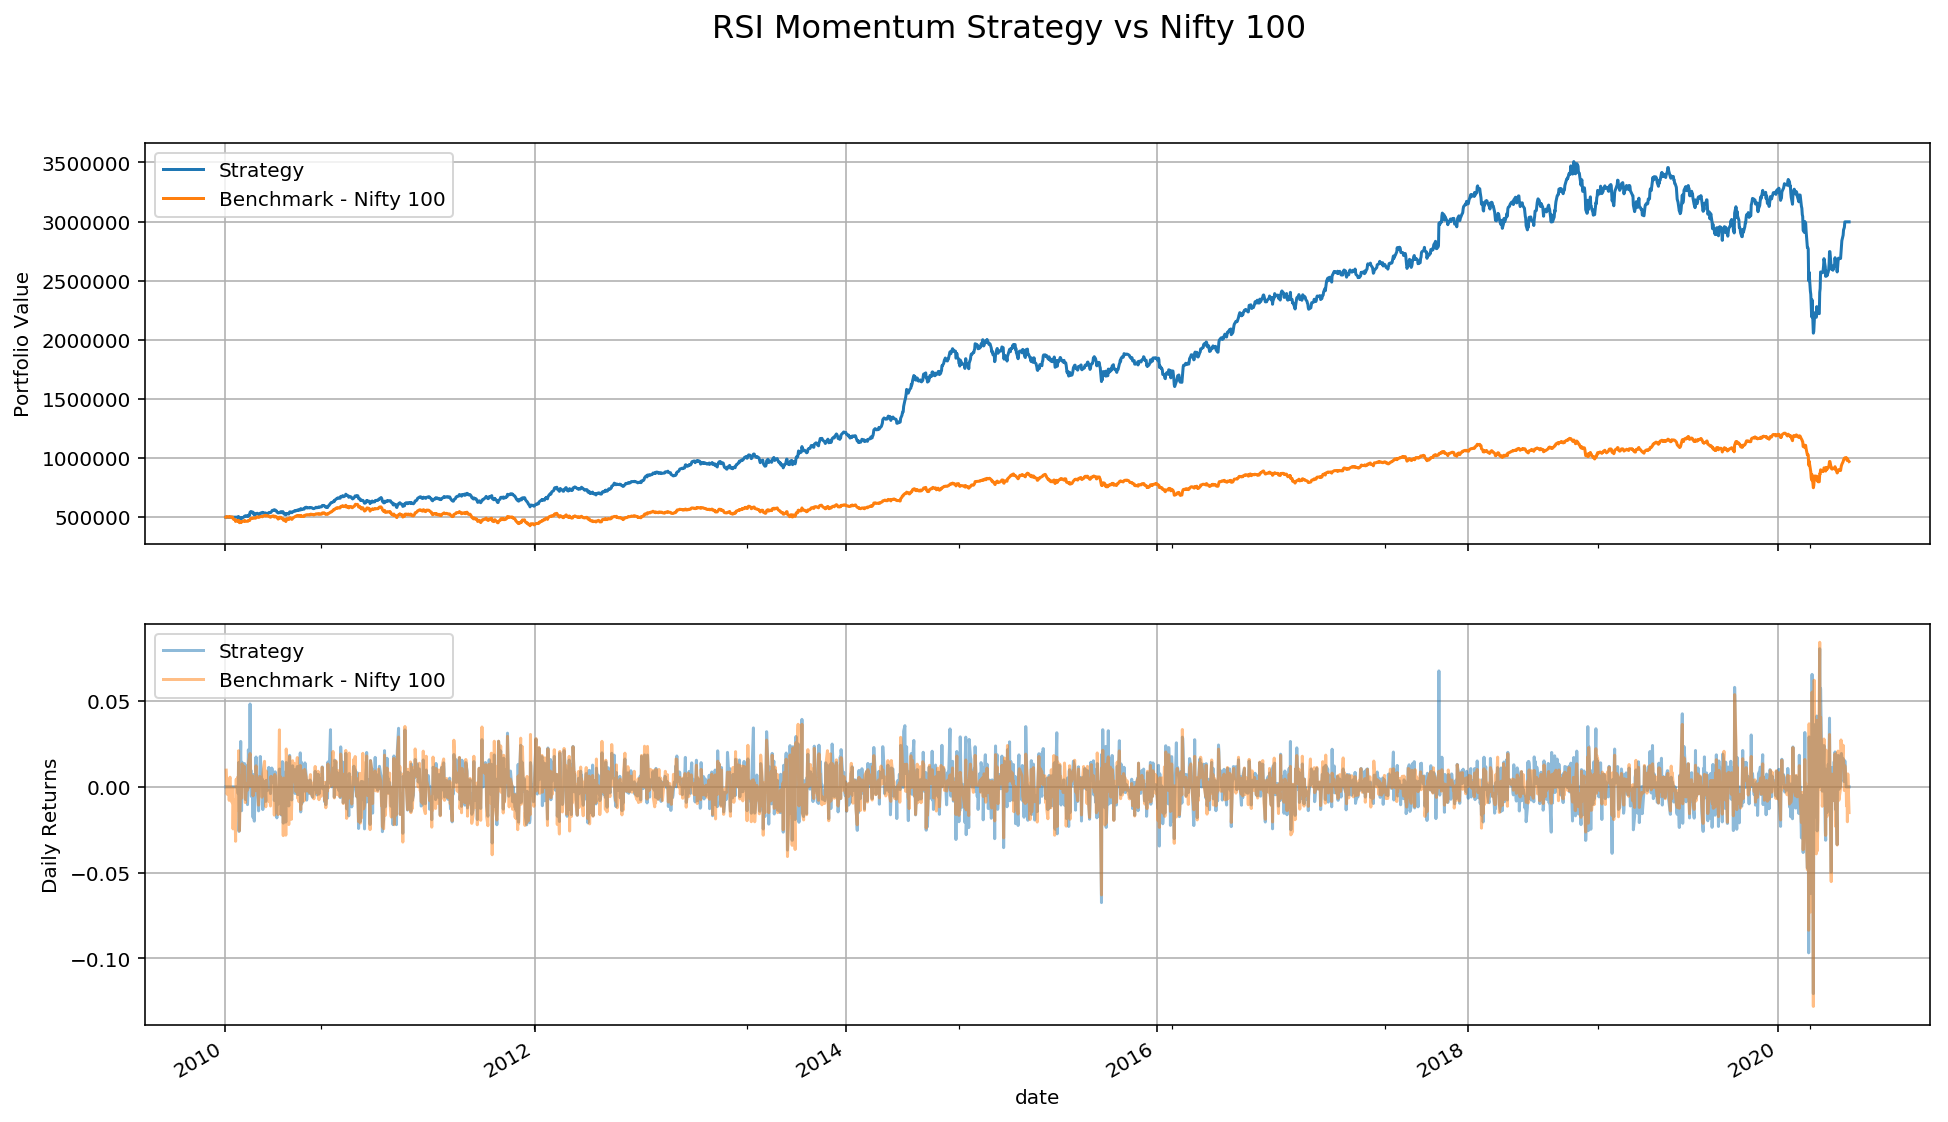

In [66]:
# Visulize the output
fig, ax = plt.subplots(2, 1, sharex=True, figsize=[16, 9])
# portfolio value
perf.portfolio_value.plot(ax=ax[0], label='Strategy')
benchmark_prices.plot(ax=ax[0], label='Benchmark - Nifty 100')
ax[0].set_ylabel('Portfolio Value')
ax[0].grid(True)
ax[0].legend()

# daily returns
perf.returns.plot(ax=ax[1], label='Strategy', alpha=0.5)
benchmark_rets.plot(ax=ax[1], label='Benchmark - Nifty 100', alpha=0.5)
ax[1].set_ylabel('Daily Returns')

fig.suptitle('RSI Momentum Strategy vs Nifty 100', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()
fig.savefig('images/chart1')

In [67]:
# Performance of benchmark on key parameters
pf.show_perf_stats(benchmark_rets)

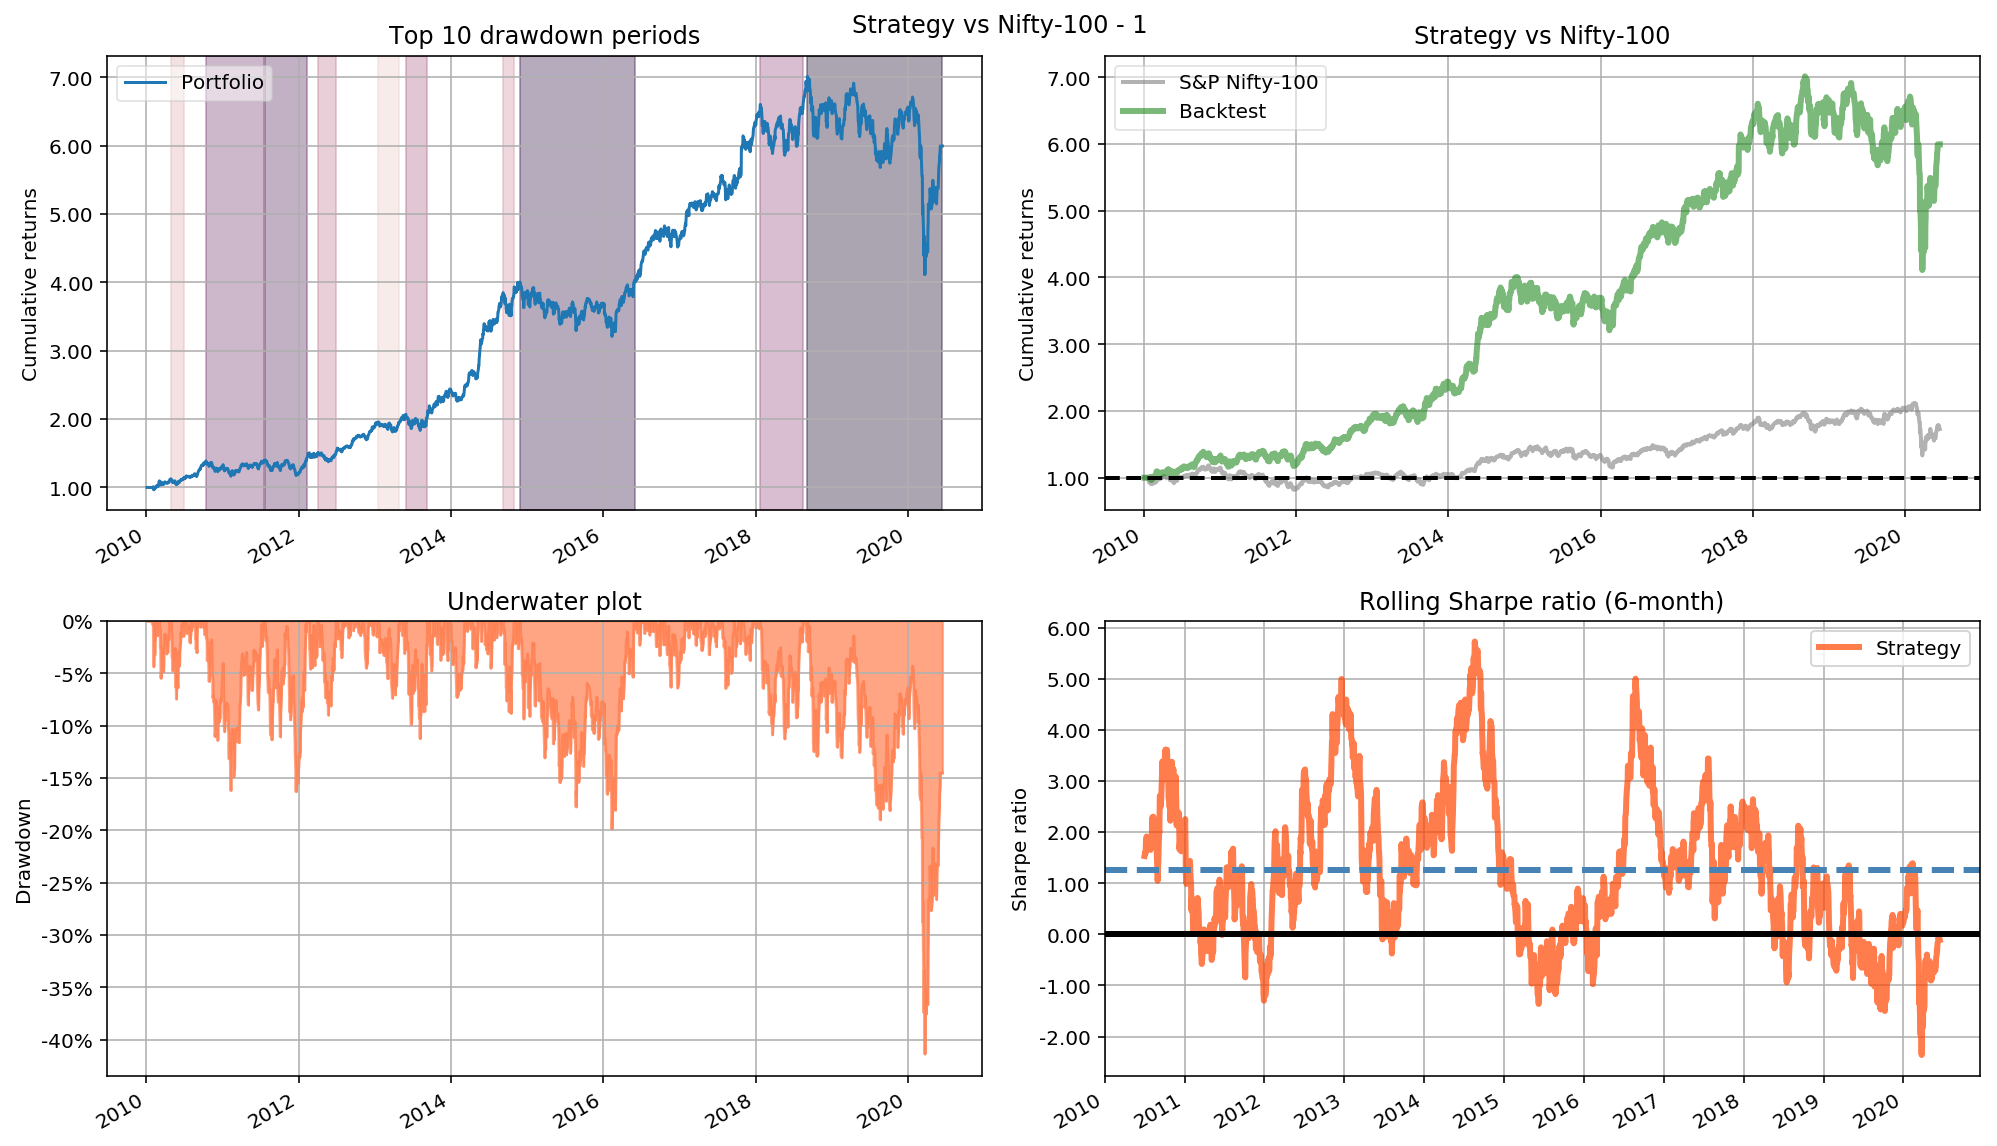

In [68]:
# plot performance for strategy
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 8),constrained_layout=True)
axes = ax.flatten()

pf.plot_drawdown_periods(returns=returns, ax=axes[0])
axes[0].grid(True)
pf.plot_rolling_returns(returns=returns,
                        factor_returns=benchmark_rets,
                        ax=axes[1], title='Strategy vs Nifty-100')
axes[1].grid(True)
pf.plot_drawdown_underwater(returns=returns, ax=axes[2])
axes[2].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[3])
axes[3].grid(True)
fig.suptitle('Strategy vs Nifty-100 - 1', fontsize=12, y=0.990)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('images/chart2', dpi=300)

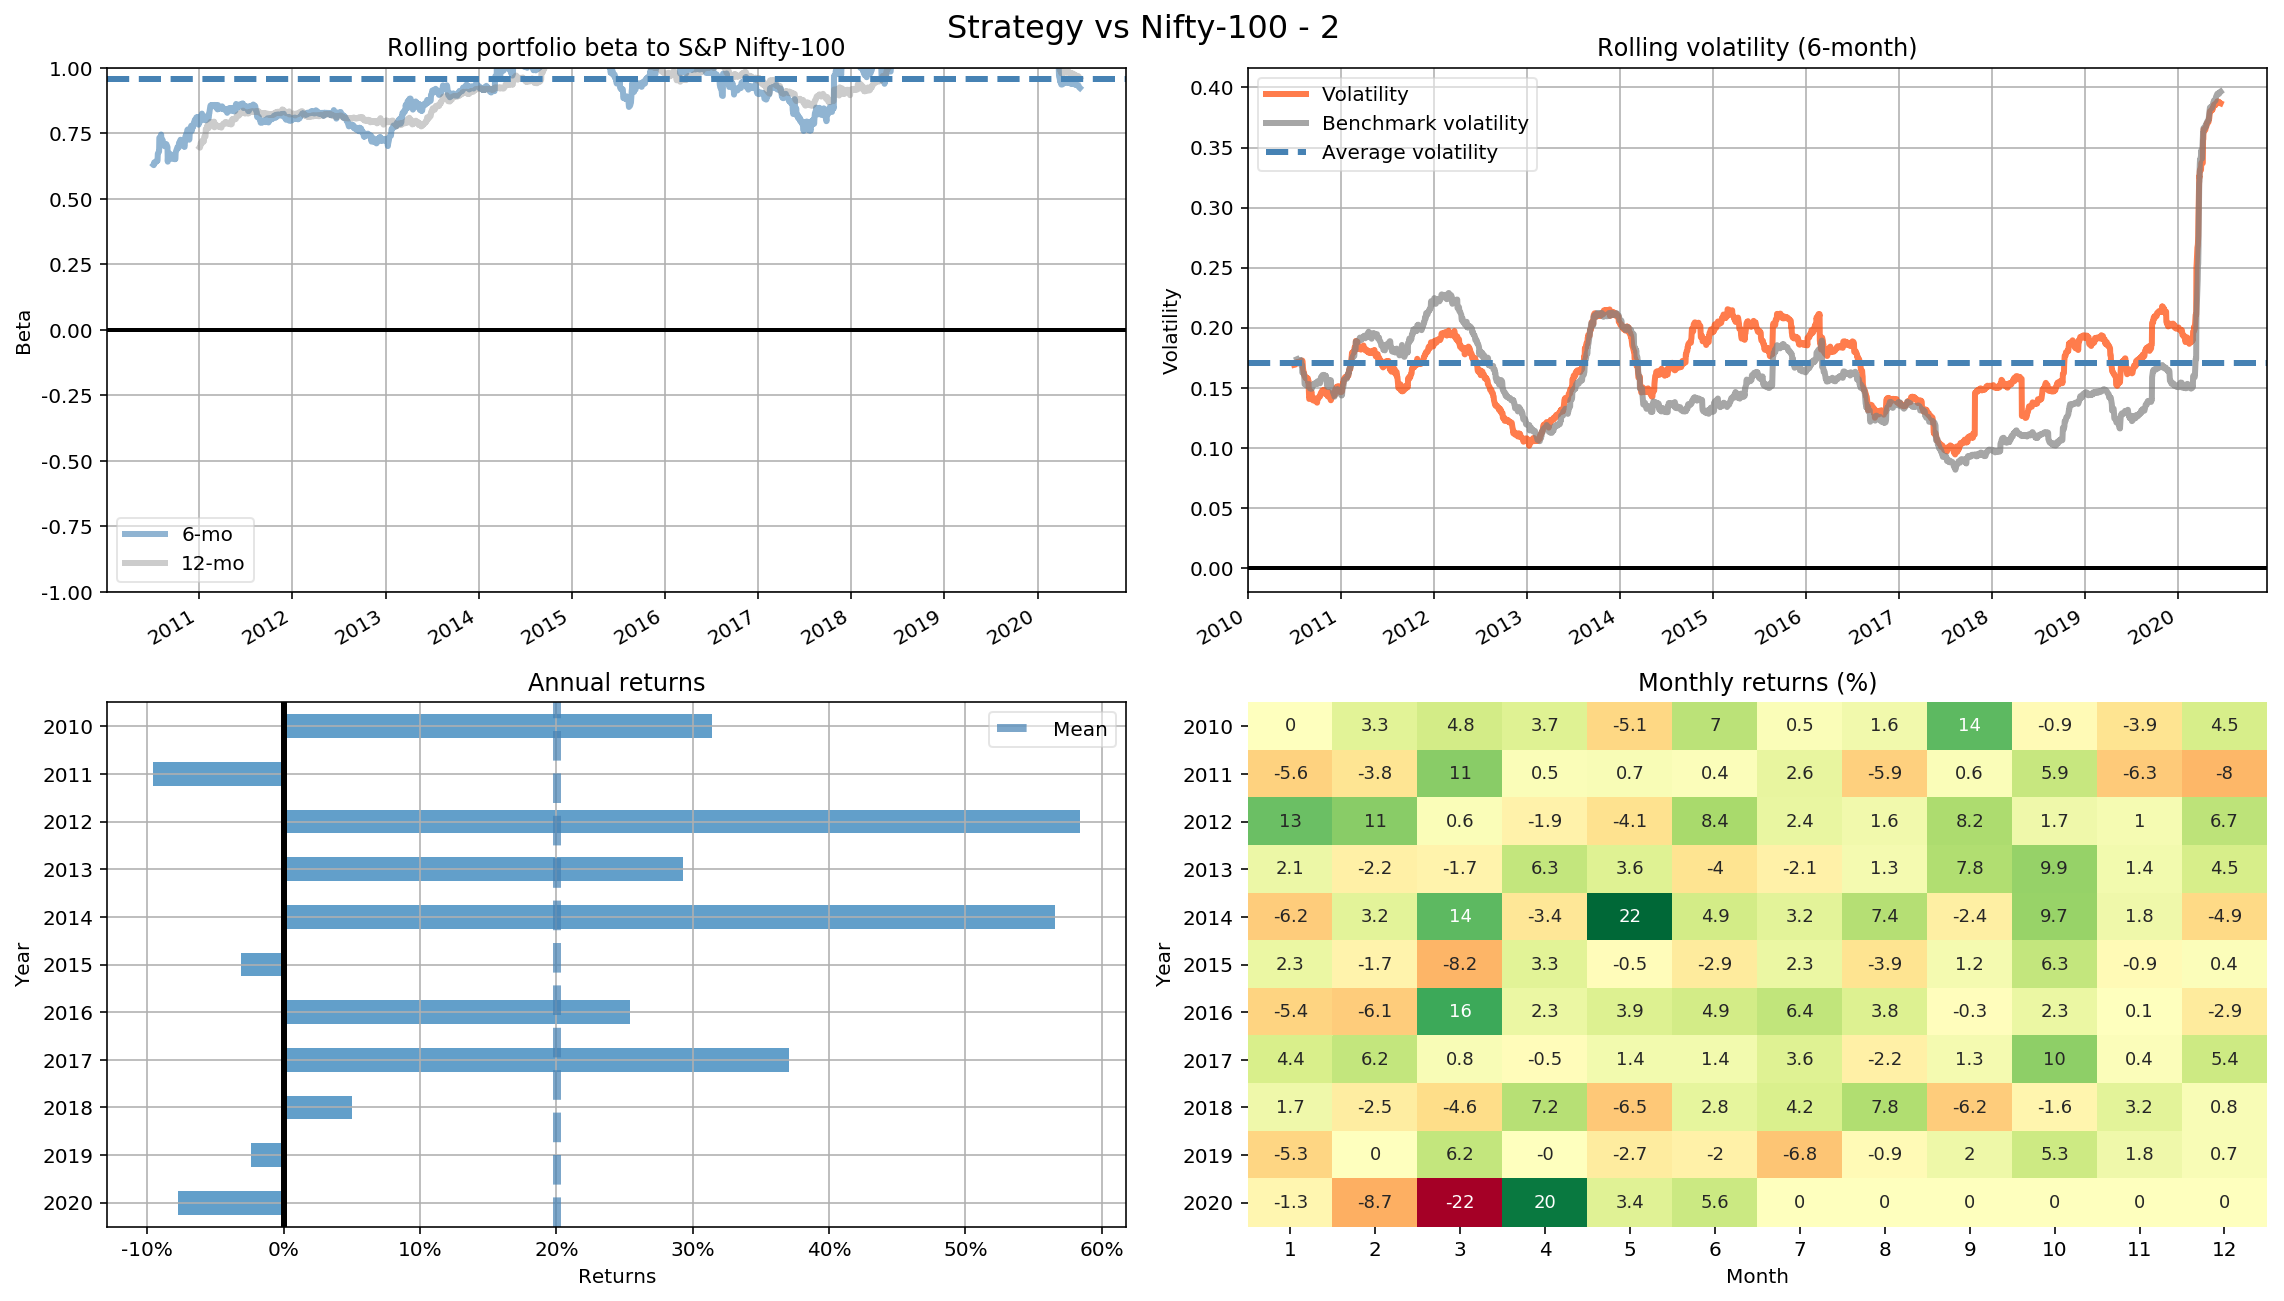

In [69]:
# plot performance
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[0])
axes[0].grid(True)

pf.plot_rolling_volatility(returns=returns, factor_returns=benchmark_rets,ax=axes[1])
axes[1].grid(True)

pf.plot_annual_returns(returns=returns, ax=axes[2])
axes[2].grid(True)

pf.plot_monthly_returns_heatmap(returns=returns, ax=axes[3],)
fig.suptitle('Strategy vs Nifty-100 - 2', fontsize=16, y=1.0)


plt.tight_layout()
plt.savefig('images/chart3', dpi=300)

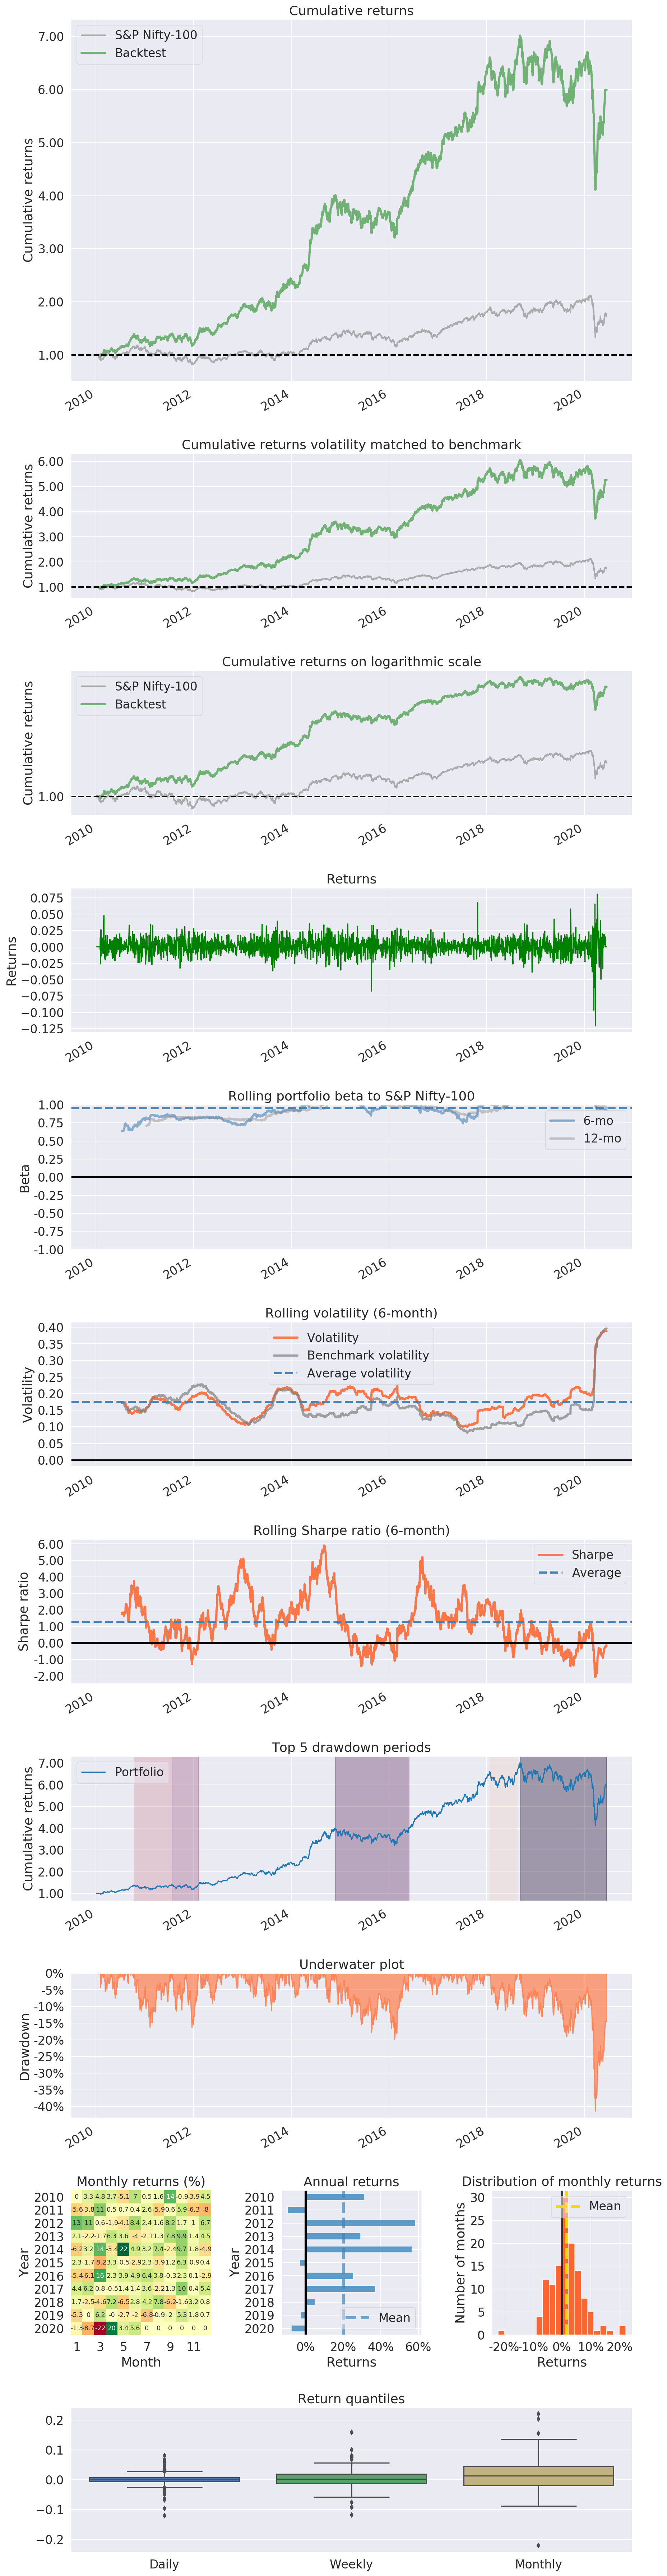

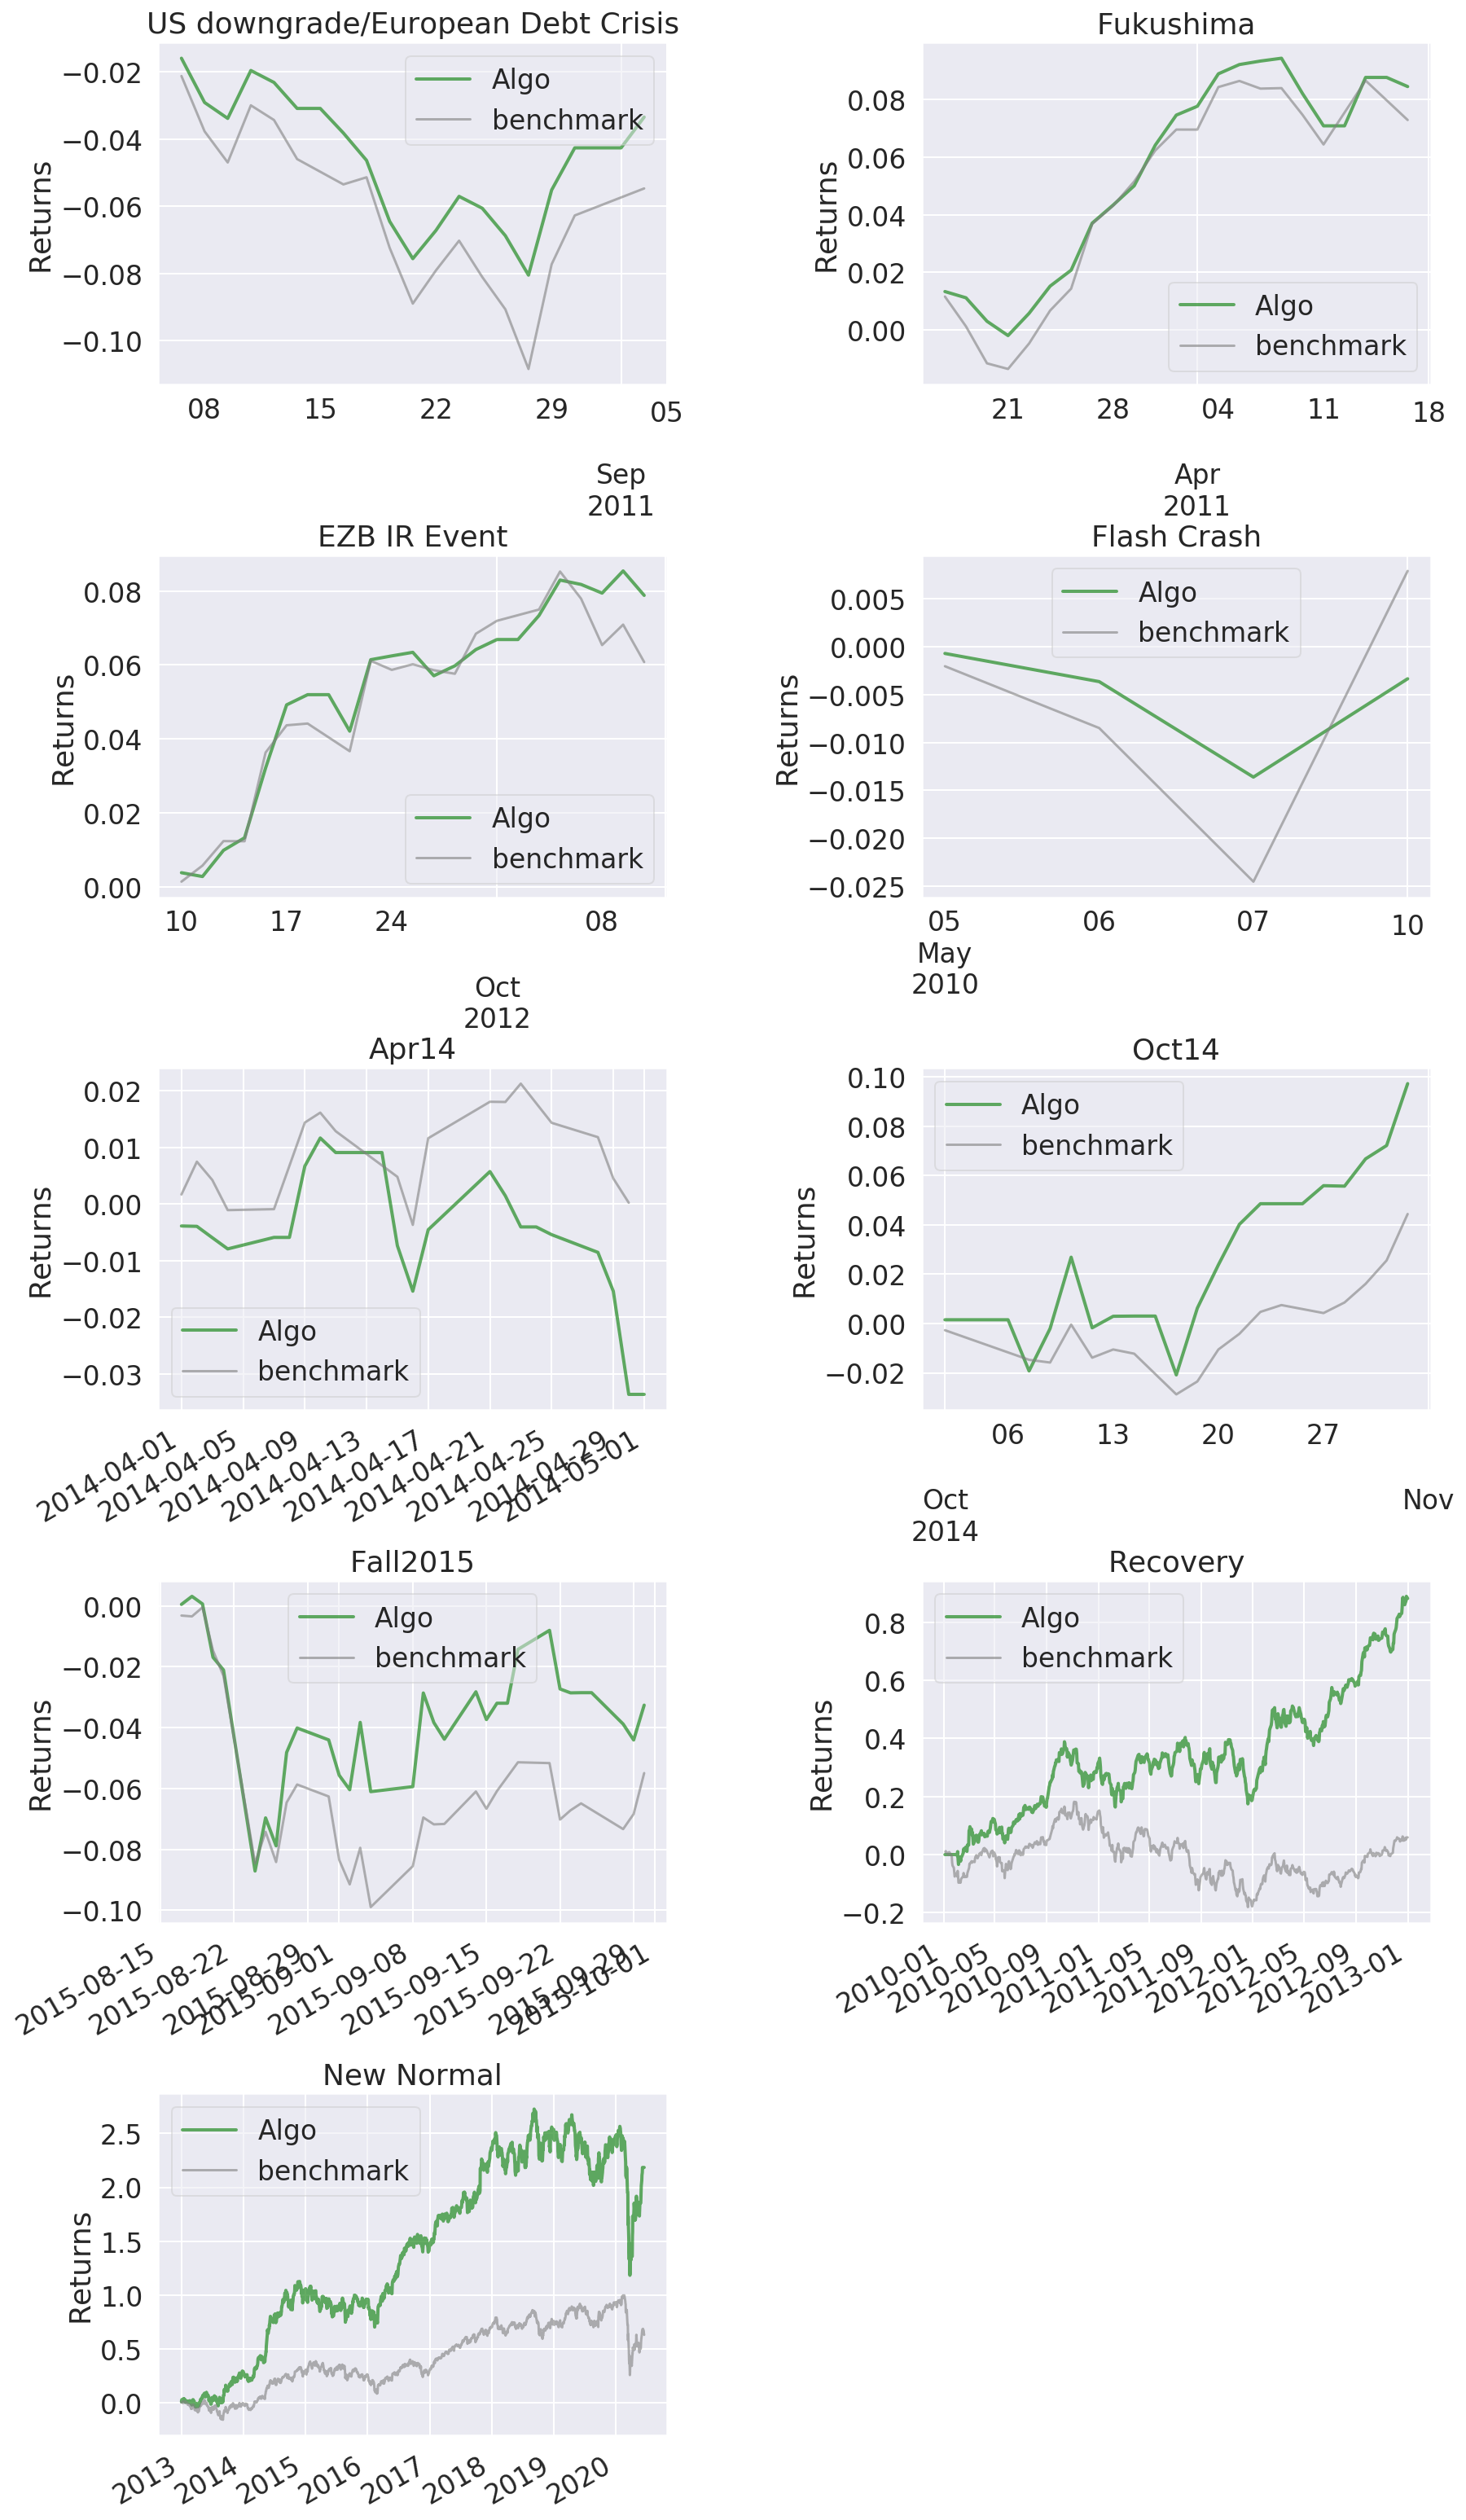

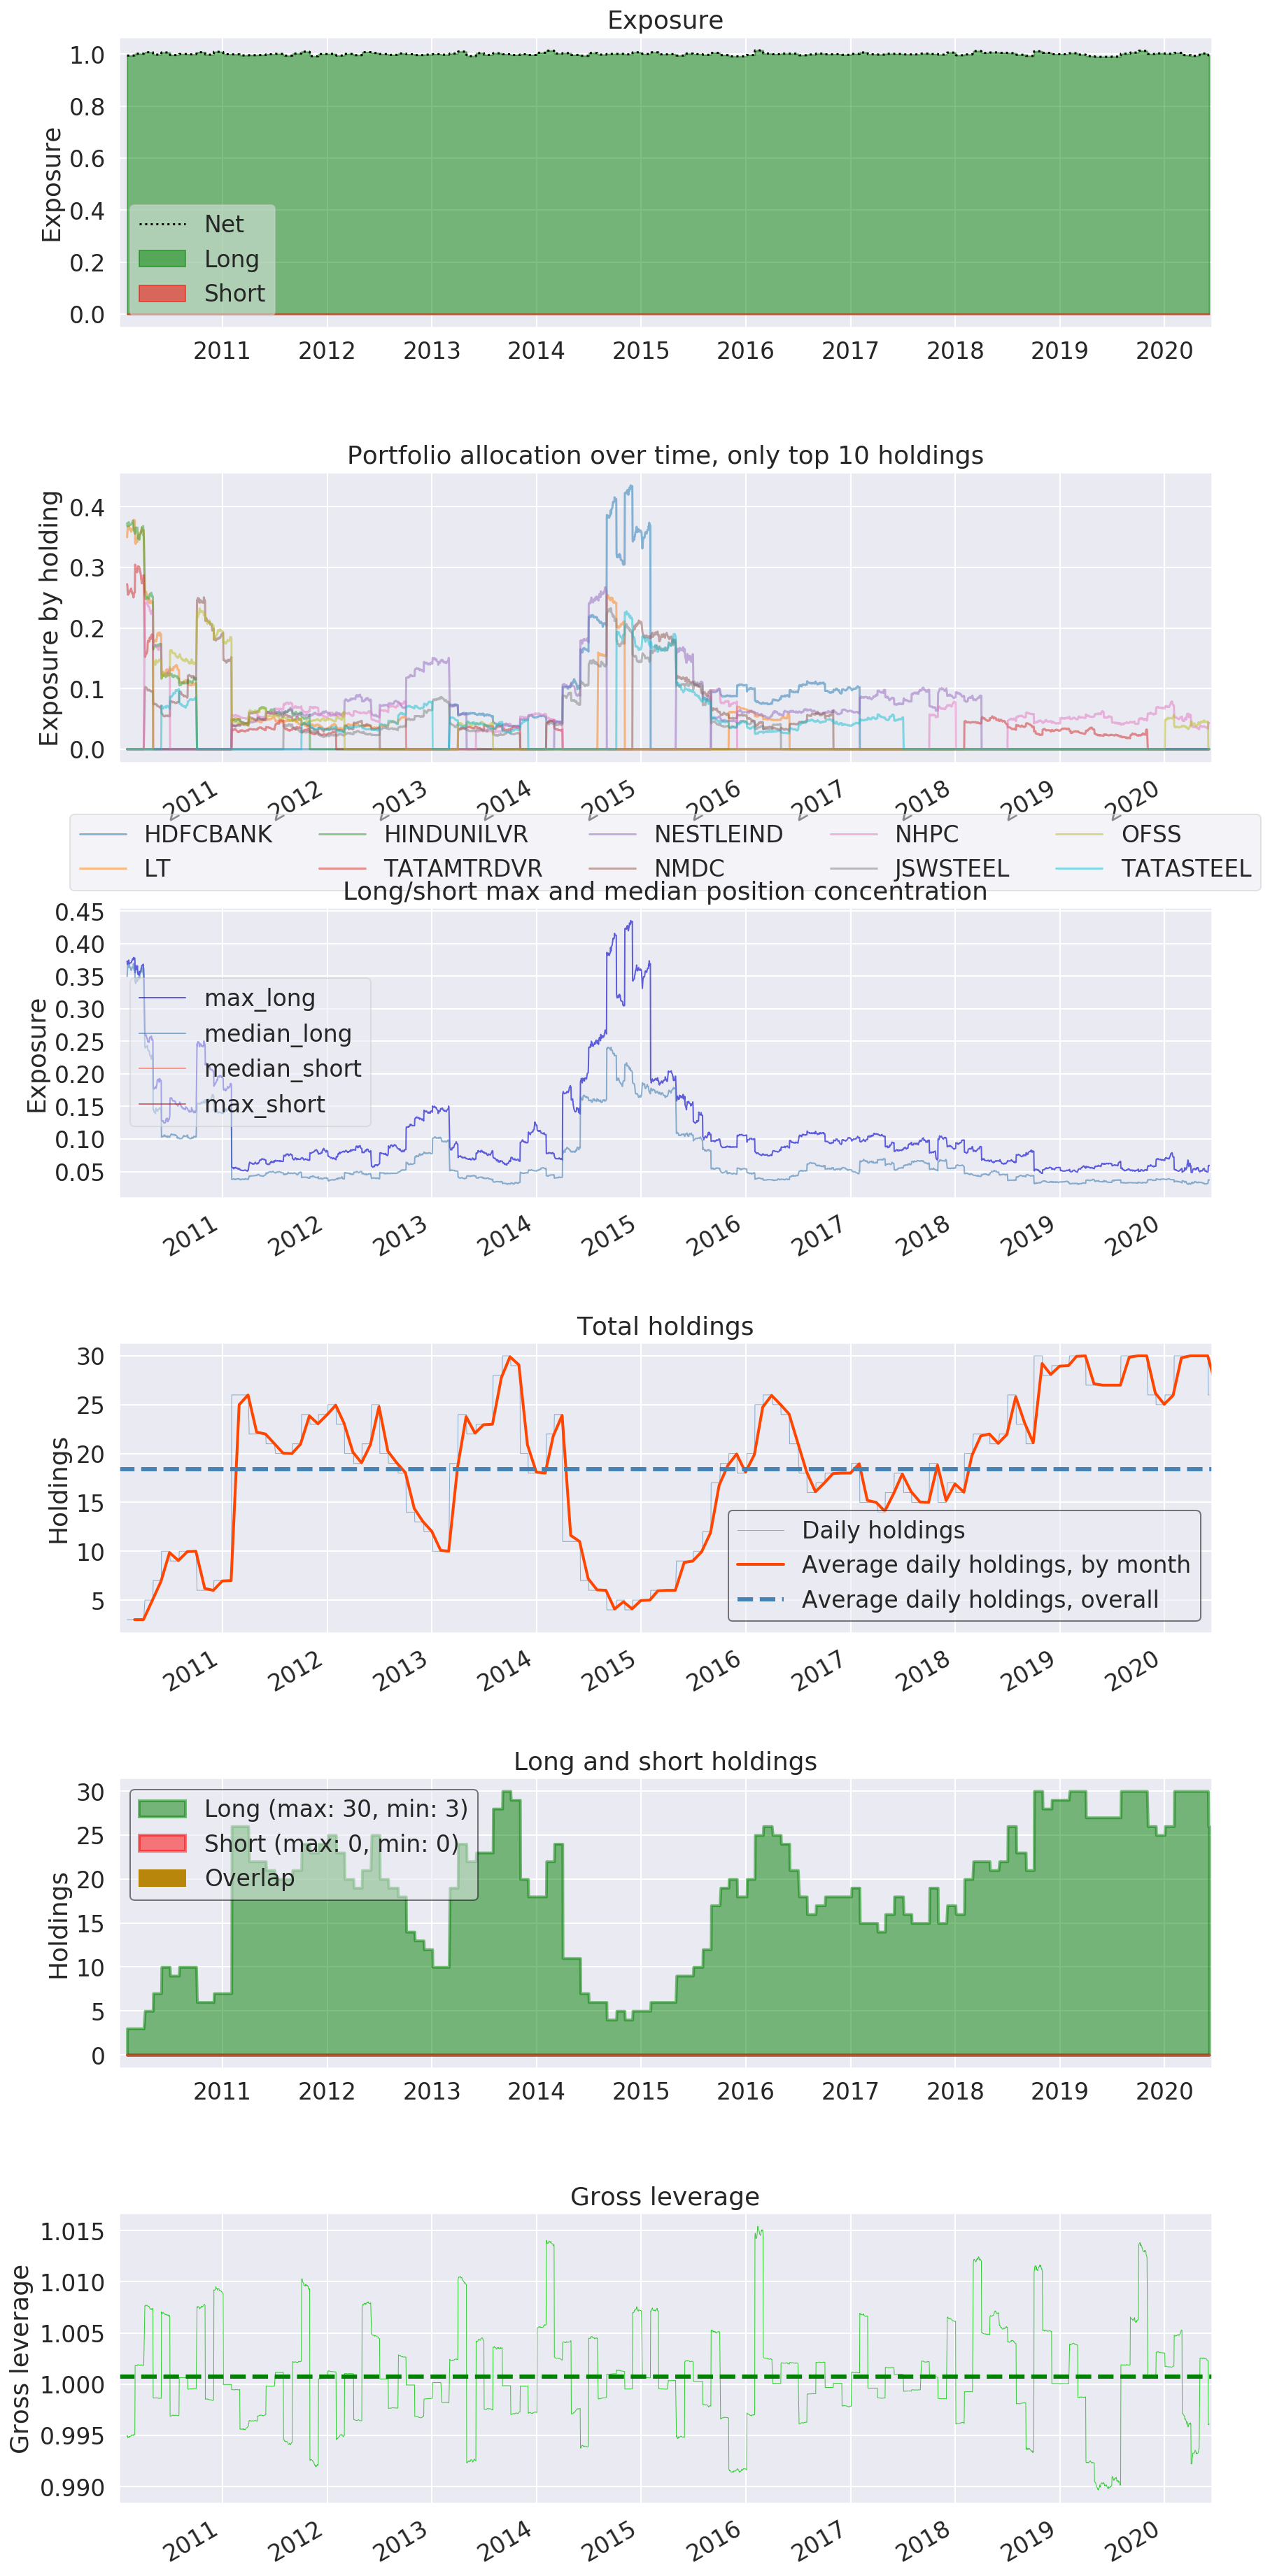

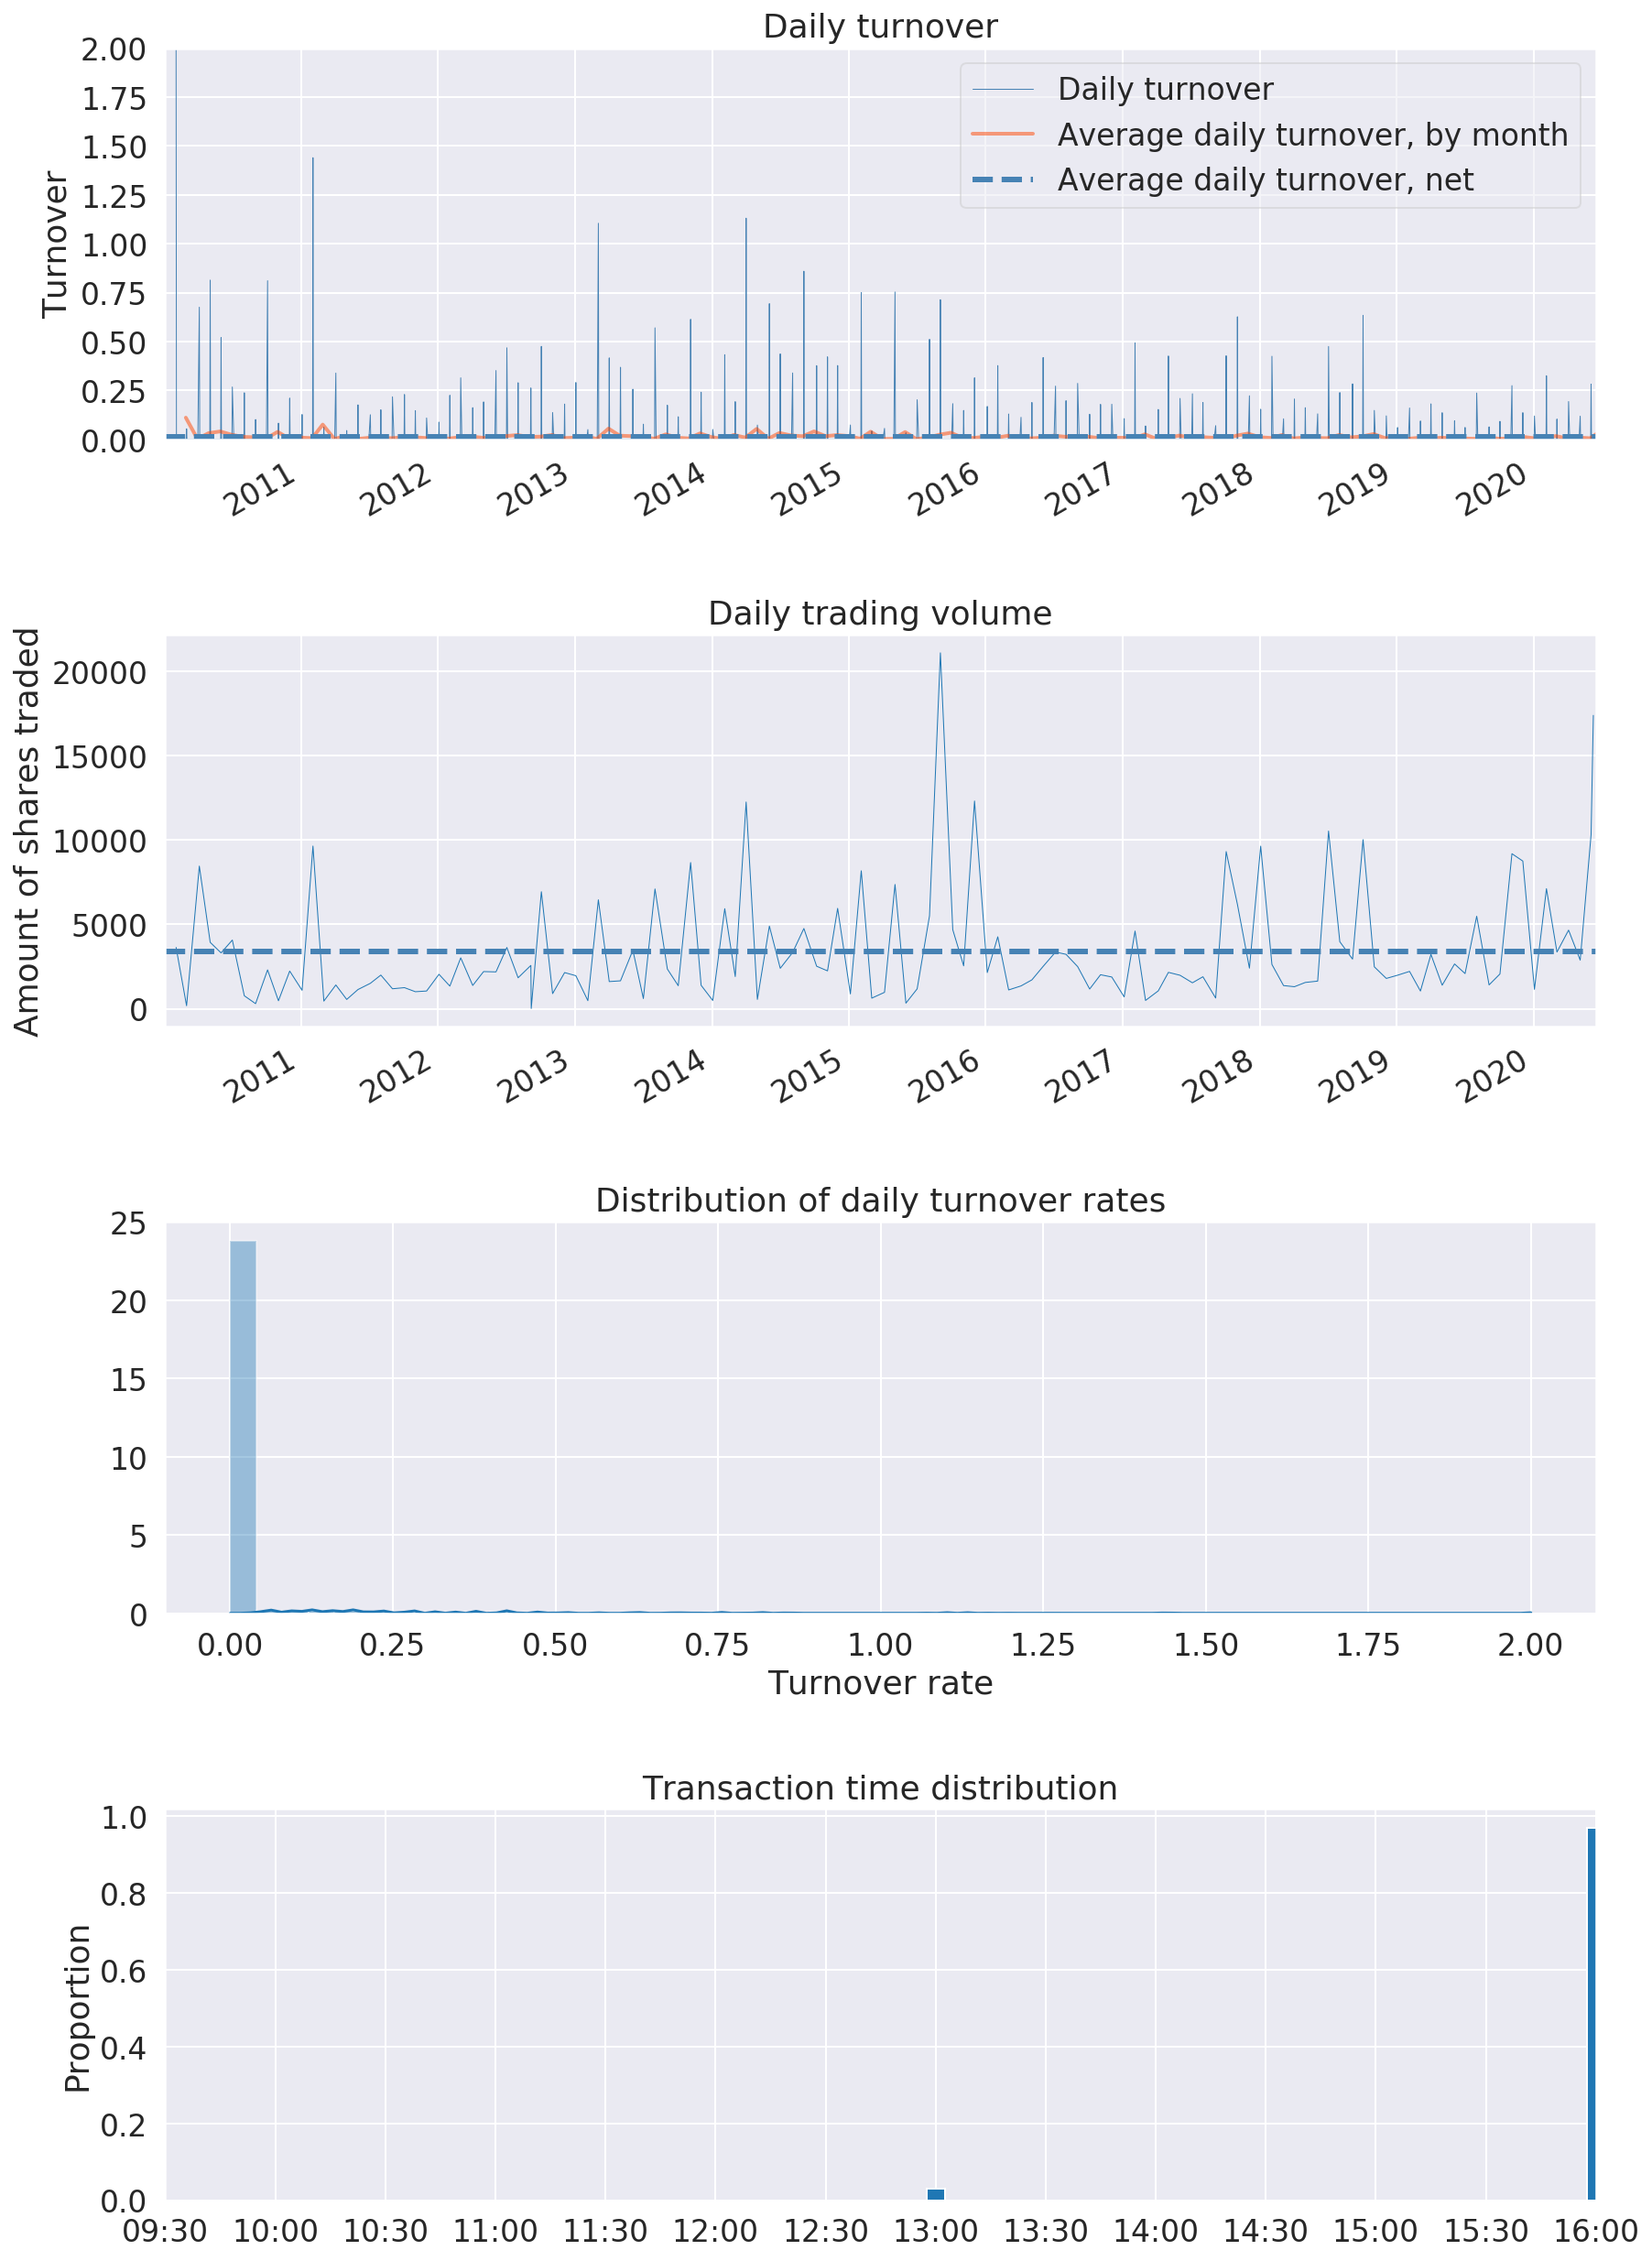

In [70]:
fig = pf.create_full_tear_sheet(returns, benchmark_rets=benchmark_rets, positions=positions, transactions=transactions)
plt.savefig('images/chart4', dpi=400)